# Scaling and Efficiency

In [1]:
# Defaults
strong_scaling_book_path = '../runs/strong_scaling'
weak_scaling_book_path = '../runs/weak_scaling'

In [2]:
import scrapbook as sb
import matplotlib.pyplot as plt
import mhpc_project.plots as plots

In [3]:
strong_scaling_book = sb.read_notebooks(strong_scaling_book_path)

## Strong Scaling

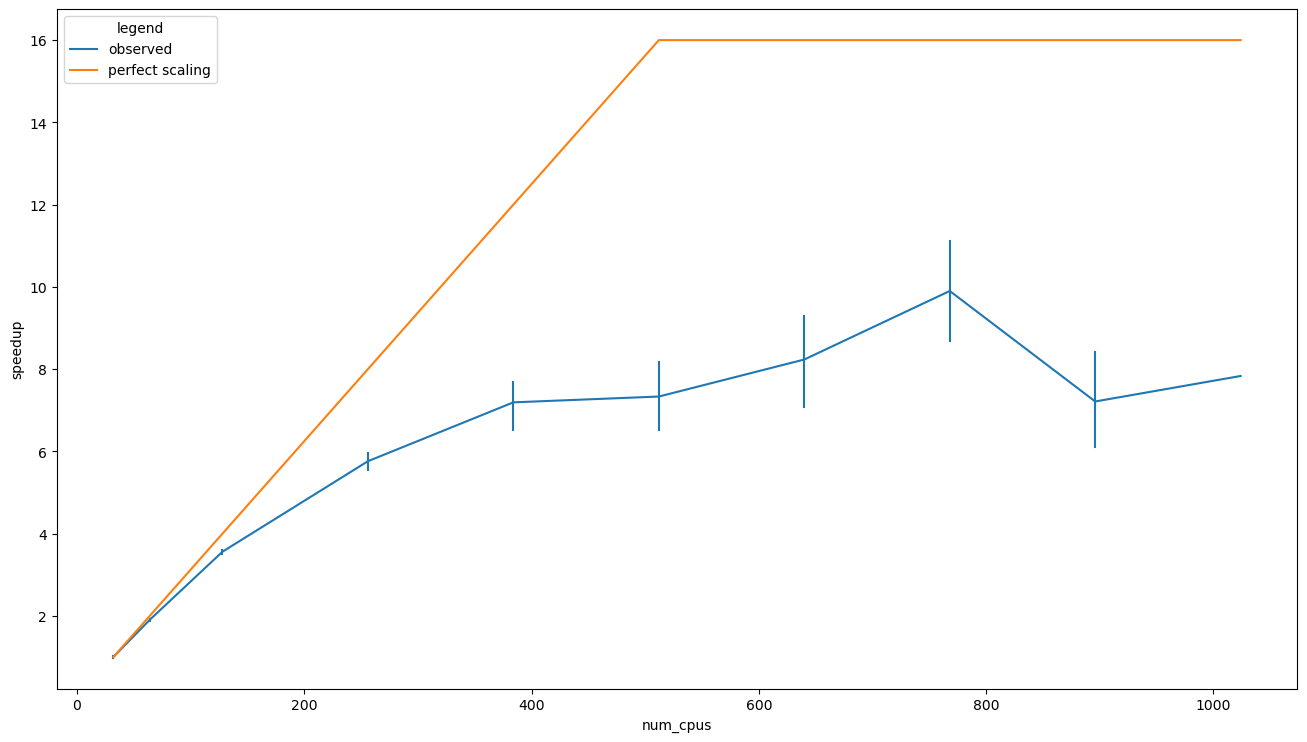

In [4]:
plots.strong_scaling(strong_scaling_book)
plt.show()

## Strong Scaling Efficiency

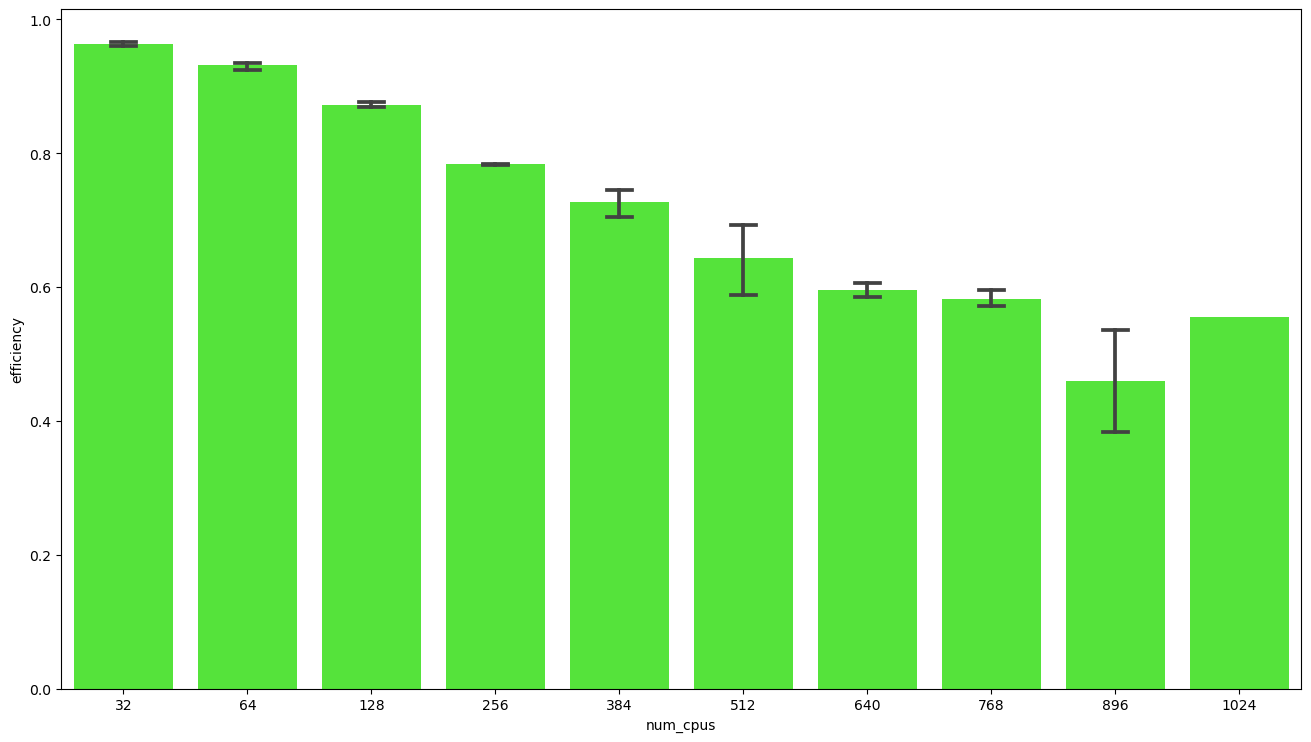

In [5]:
plots.efficiency(strong_scaling_book)
plt.show()

In [6]:
weak_scaling_book = sb.read_notebooks(weak_scaling_book_path)

## Weak Scaling

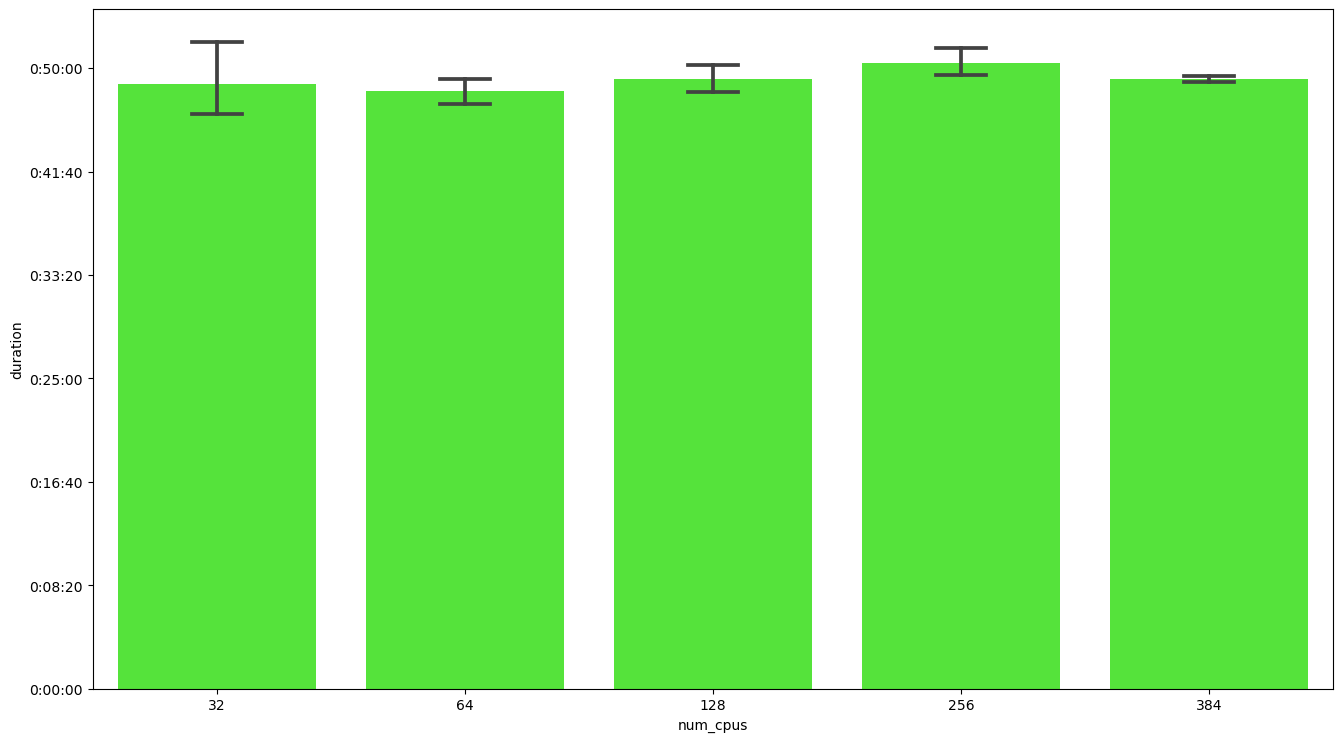

In [7]:
plots.weak_scaling(weak_scaling_book)
plt.show()


## Weak Scaling Efficiency

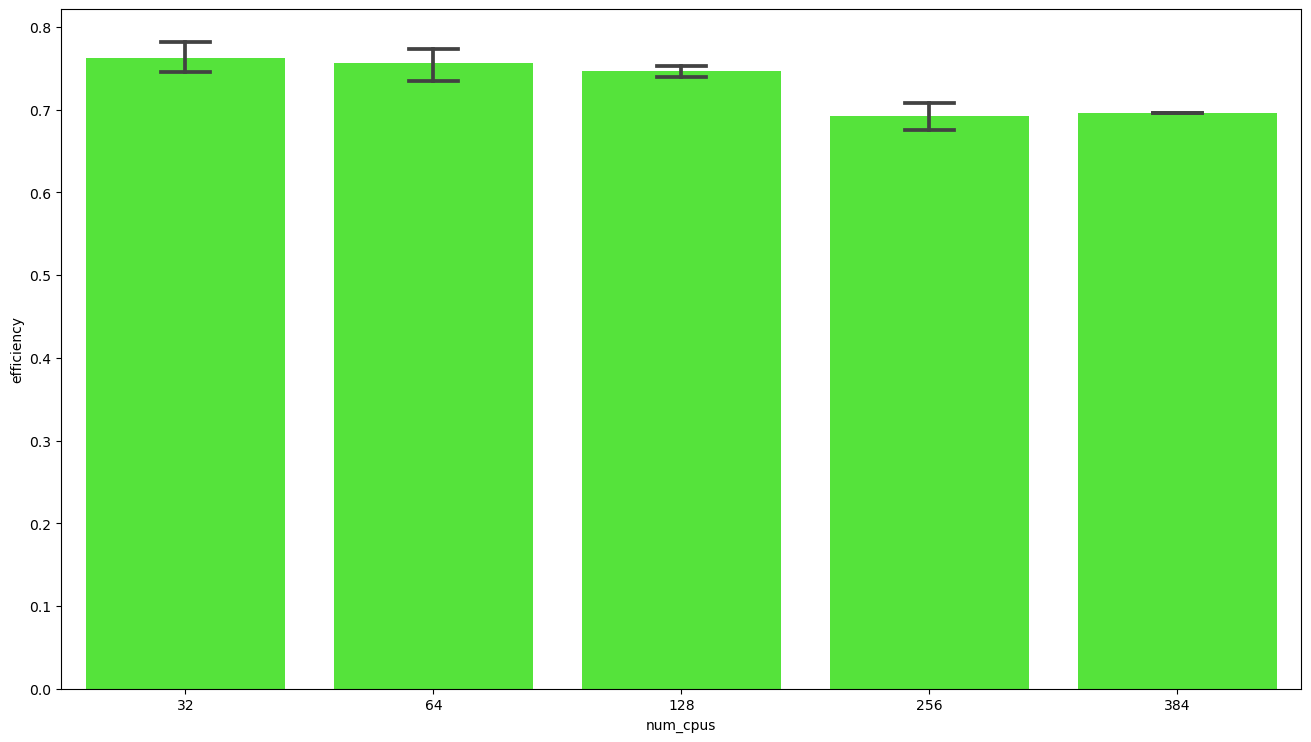

In [8]:
plots.efficiency(weak_scaling_book)
plt.show()

In [10]:
nb = sb.read_notebook('../runs/strong_scaling/testbed-NGO-4096-1024-Xe4.ipynb')

In [24]:
gen_loss = [(g[0], l) for g, l, _ in nb.scraps['log'].data]

In [26]:
import pandas as pd
import seaborn as sns

In [49]:
df = pd.DataFrame.from_records(gen_loss, columns=['generation', 'loss'])

In [43]:
df = df.drop(df.index[df['loss'] == 'nan'])

<AxesSubplot:xlabel='generation', ylabel='Count'>

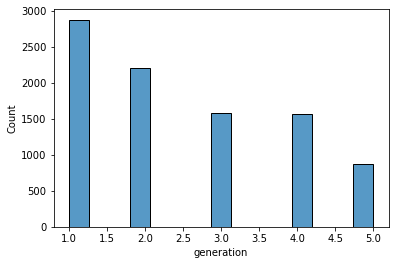

In [55]:
sns.histplot(data=df[df['loss'] != 'nan'], x='generation')

In [56]:
df[df['loss'] != 'nan'].count()

generation    9099
loss          9099
dtype: int64

<AxesSubplot:xlabel='generation', ylabel='Count'>

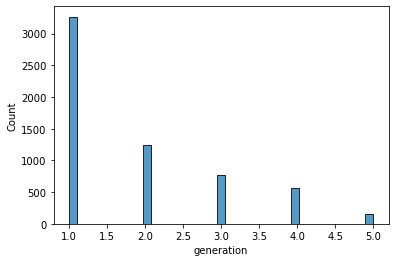

In [53]:
sns.histplot(data=df[df['loss'] == 'nan'], x='generation')